<a href="https://colab.research.google.com/github/JJang-404/team_tasks/blob/main/A07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import json
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from torchvision import transforms
import glob
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA available: True


## 2. Dataset 클래스 정의

In [33]:
class PillDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms

        # 모든 이미지 파일 목록
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

        # 카테고리 ID 매핑 생성 (1부터 시작, 0은 배경)
        self.category_mapping = {}
        self.load_categories()

    def load_categories(self):
        """모든 어노테이션에서 카테고리 수집"""
        category_ids = set()

        for img_file in self.image_files:
            img_name = img_file.replace('.png', '')
            ann_folder = os.path.join(self.annotation_dir, img_name)

            if not os.path.exists(ann_folder):
                continue

            # 해당 폴더 내 모든 JSON 파일 읽기
            json_files = glob.glob(os.path.join(ann_folder, '*/*.json'))

            for json_file in json_files:
                with open(json_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    for ann in data.get('annotations', []):
                        category_ids.add(ann['category_id'])

        # 카테고리 ID를 1부터 시작하는 연속된 번호로 매핑
        sorted_ids = sorted(category_ids)
        self.category_mapping = {old_id: new_id + 1 for new_id, old_id in enumerate(sorted_ids)}
        self.num_classes = len(self.category_mapping) + 1  # +1 for background

        print(f"Total categories found: {len(self.category_mapping)}")
        print(f"Number of classes (including background): {self.num_classes}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 이미지 로드
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')

        # 이미지 크기
        img_width, img_height = img.size

        # 어노테이션 로드
        img_name_base = img_name.replace('.png', '')
        ann_folder = os.path.join(self.annotation_dir, img_name_base)

        boxes = []
        labels = []

        if os.path.exists(ann_folder):
            # 해당 폴더 내 모든 JSON 파일 읽기
            json_files = glob.glob(os.path.join(ann_folder, '*/*.json'))

            for json_file in json_files:
                try:
                    with open(json_file, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                        for ann in data.get('annotations', []):
                            bbox = ann.get('bbox', [])

                            # bbox 유효성 검증
                            if not bbox or len(bbox) != 4:
                                print(f"Warning: Invalid bbox in {json_file}: {bbox}")
                                continue

                            x, y, w, h = bbox

                            # 너비와 높이가 0보다 큰지 확인
                            if w <= 0 or h <= 0:
                                print(f"Warning: Invalid box dimensions in {json_file}: w={w}, h={h}")
                                continue

                            # [x_min, y_min, x_max, y_max] 형식으로 변환
                            x_min, y_min = x, y
                            x_max, y_max = x + w, y + h

                            # 박스가 이미지 경계 내에 있는지 확인
                            x_min = max(0, min(x_min, img_width))
                            y_min = max(0, min(y_min, img_height))
                            x_max = max(0, min(x_max, img_width))
                            y_max = max(0, min(y_max, img_height))

                            # 변환 후에도 유효한 박스인지 확인
                            if x_max > x_min and y_max > y_min:
                                boxes.append([x_min, y_min, x_max, y_max])

                                # 카테고리 ID 매핑
                                original_cat_id = ann['category_id']
                                mapped_cat_id = self.category_mapping.get(original_cat_id, 1)
                                labels.append(mapped_cat_id)
                            else:
                                print(f"Warning: Box became invalid after clipping in {json_file}")

                except Exception as e:
                    print(f"Error processing {json_file}: {str(e)}")
                    continue

        # 어노테이션이 없는 경우 빈 박스 처리
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        # 이미지를 텐서로 변환
        img = transforms.ToTensor()(img)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        return img, target

## 3. 데이터셋 로드 및 확인

In [25]:
import os

# /content/traindata.zip 압축 해제
TRAINDATA_DIR = '/content/traindata'
if not os.path.exists(TRAINDATA_DIR):
    if os.path.exists('/content/traindata.zip'):
        print("Unzipping traindata.zip...")
        # traindata/train_images, traindata/train_annotations 경로가 /content 아래에 생성되도록 합니다.
        !unzip -q '/content/traindata.zip' -d '/content'
        print("traindata.zip unzipped.")
    else:
        print("traindata.zip not found at /content/traindata.zip.")
else:
    print(f"{TRAINDATA_DIR} already unzipped.")

# /content/test_images.zip 압축 해제
TEST_IMAGES_DIR = '/content/test_images'
if not os.path.exists(TEST_IMAGES_DIR):
    if os.path.exists('/content/test_images.zip'):
        print("Unzipping test_images.zip...")
        # test_images 폴더가 루트 디렉토리 (Colab 환경에서 보통 /) 아래에 생성되도록 합니다.
        !unzip -q '/content/test_images.zip' -d '/content'
        print("test_images.zip unzipped.")
    else:
        print("test_images.zip not found at /content/test_images.zip.")
else:
    print(f"{TEST_IMAGES_DIR} already unzipped.")

print("Contents of / directory after unzipping:")
!ls -R /
print("\nContents of /content directory after unzipping:")
!ls -R /content

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
libmount1:amd64.md5sums
libmount1:amd64.shlibs
libmount1:amd64.symbols
libmount1:amd64.triggers
libmount-dev:amd64.list
libmount-dev:amd64.md5sums
libmp3lame0:amd64.list
libmp3lame0:amd64.md5sums
libmp3lame0:amd64.shlibs
libmp3lame0:amd64.symbols
libmp3lame0:amd64.triggers
libmpc3:amd64.list
libmpc3:amd64.md5sums
libmpc3:amd64.shlibs
libmpc3:amd64.symbols
libmpc3:amd64.triggers
libmpdec3:amd64.list
libmpdec3:amd64.md5sums
libmpdec3:amd64.shlibs
libmpdec3:amd64.symbols
libmpdec3:amd64.triggers
libmpfr6:amd64.list
libmpfr6:amd64.md5sums
libmpfr6:amd64.shlibs
libmpfr6:amd64.symbols
libmpfr6:amd64.triggers
libmpg123-0:amd64.list
libmpg123-0:amd64.md5sums
libmpg123-0:amd64.shlibs
libmpg123-0:amd64.symbols
libmpg123-0:amd64.triggers
libmumps-5.4:amd64.list
libmumps-5.4:amd64.md5sums
libmumps-5.4:amd64.shlibs
libmumps-5.4:amd64.triggers
libmumps-dev:amd64.list
libmumps-dev:amd64.md5sums
libmumps-headers-dev.list
libmumps-headers-dev.md5sums
libmumps-seq-5.4

압축 해제 하지말자

In [26]:
# 경로 설정
TRAIN_IMAGE_DIR = '/content/traindata/train_images'
TRAIN_ANNOTATION_DIR = '/content/traindata/train_annotations'
TEST_IMAGE_DIR = '/content/test_images'

# 데이터셋 생성
print("Loading dataset...")
dataset = PillDataset(TRAIN_IMAGE_DIR, TRAIN_ANNOTATION_DIR)
print(f"\nTotal training images: {len(dataset)}")

Loading dataset...
Total categories found: 18
Number of classes (including background): 19

Total training images: 137


## 4. 샘플 데이터 시각화

Image shape: torch.Size([3, 1280, 976])
Number of objects: 3
Boxes: tensor([[ 134.,  290.,  325.,  485.],
        [ 134.,  290.,  325.,  485.],
        [ 410.,  865.,  601., 1058.]])
Labels: tensor([5, 5, 2])


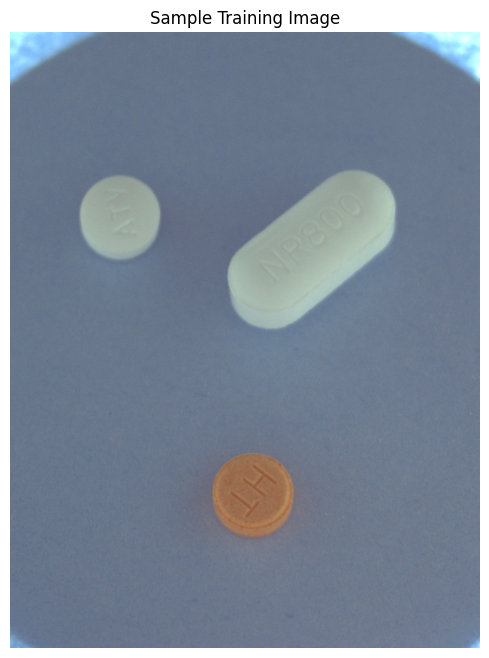

In [27]:
# 샘플 이미지 확인
sample_img, sample_target = dataset[0]

print(f"Image shape: {sample_img.shape}")
print(f"Number of objects: {len(sample_target['boxes'])}")
print(f"Boxes: {sample_target['boxes']}")
print(f"Labels: {sample_target['labels']}")

# 이미지 시각화
plt.figure(figsize=(12, 8))
img_np = sample_img.permute(1, 2, 0).numpy()
plt.imshow(img_np)
plt.title("Sample Training Image")
plt.axis('off')
plt.show()

## 5. 모델 생성 함수

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Hyperparameters
BATCH_SIZE = 2
NUM_WORKERS = 0

# 데이터 로더 생성
data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

print(f"Number of batches: {len(data_loader)}")

Number of batches: 69


In [35]:
from torchvision.ops import box_iou

def calculate_map50(model, data_loader, device, iou_threshold=0.5, confidence_threshold=0.5):
    """
    mAP50 계산 함수
    """
    model.eval()
    all_precisions = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 예측
            predictions = model(images)

            # 각 이미지에 대해 평가
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes']
                pred_scores = pred['scores']
                pred_labels = pred['labels']

                gt_boxes = target['boxes']
                gt_labels = target['labels']

                # Ground truth가 없으면 스킵
                if len(gt_boxes) == 0:
                    continue

                # Confidence threshold 적용
                mask = pred_scores >= confidence_threshold
                pred_boxes = pred_boxes[mask]
                pred_labels = pred_labels[mask]
                pred_scores = pred_scores[mask]

                # 예측이 없으면 precision = 0
                if len(pred_boxes) == 0:
                    all_precisions.append(0.0)
                    continue

                # IoU 계산
                ious = box_iou(pred_boxes, gt_boxes)

                # 각 예측에 대해 최대 IoU 찾기
                max_ious, max_indices = ious.max(dim=1)

                # IoU > threshold이고 클래스가 일치하는 경우 True Positive
                tp = 0
                for i, (max_iou, max_idx) in enumerate(zip(max_ious, max_indices)):
                    if max_iou >= iou_threshold and pred_labels[i] == gt_labels[max_idx]:
                        tp += 1

                # Precision 계산
                precision = tp / len(pred_boxes) if len(pred_boxes) > 0 else 0
                all_precisions.append(precision)

    # mAP50 계산 (모든 precision의 평균)
    map50 = sum(all_precisions) / len(all_precisions) if len(all_precisions) > 0 else 0
    return map50


def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """한 에폭 학습"""
    model.train()
    running_loss = 0.0
    epoch_losses = []

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        epoch_losses.append(losses.item())

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch}], Step [{i+1}/{len(data_loader)}], Loss: {losses.item():.4f}")

    avg_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")
    return avg_loss, epoch_losses

## 6. Collate Function 및 DataLoader

In [29]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Hyperparameters
BATCH_SIZE = 2
NUM_WORKERS = 0

# 데이터 로더 생성
data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

print(f"Number of batches: {len(data_loader)}")

Number of batches: 69


## 7. 학습 함수 정의

In [30]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """한 에폭 학습"""
    model.train()
    running_loss = 0.0
    epoch_losses = []

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        epoch_losses.append(losses.item())

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch}], Step [{i+1}/{len(data_loader)}], Loss: {losses.item():.4f}")

    avg_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")
    return avg_loss, epoch_losses

## 8. 모델 학습 설정

In [36]:
# Device 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# 모델 생성
print(f"\nCreating model with {dataset.num_classes} classes...")
model = create_model(dataset.num_classes)
model.to(device)

# Hyperparameters
NUM_EPOCHS = 50
LEARNING_RATE = 0.005
MODEL_SAVE_DIR = '/content/models'  # 코랩 환경 경로
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'faster_rcnn_pill_model.pth')

# 모델 저장 디렉토리 생성 (없으면 생성)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Model will be saved to: {MODEL_SAVE_PATH}")

# Optimizer 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("Model setup complete!")

Using device: cuda

Creating model with 19 classes...
Model will be saved to: /content/models/faster_rcnn_pill_model.pth
Model setup complete!


## 9. 모델 학습

In [37]:
import csv

# 학습 기록
train_losses = []
map50_scores = []
epoch_results = []

print("Starting training...")
for epoch in range(1, NUM_EPOCHS + 1):
    avg_loss, epoch_losses = train_one_epoch(model, optimizer, data_loader, device, epoch)
    train_losses.append(avg_loss)

    # mAP50 계산
    print(f"Calculating mAP50 for epoch {epoch}...")
    map50 = calculate_map50(model, data_loader, device)
    map50_scores.append(map50)
    print(f"Epoch [{epoch}] mAP50: {map50:.4f}")

    # 결과 저장
    epoch_results.append({
        'epoch': epoch,
        'loss': avg_loss,
        'map50': map50
    })

    lr_scheduler.step()

    # 모델 저장 (매 10 epoch마다)
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'num_classes': dataset.num_classes,
            'category_mapping': dataset.category_mapping,
            'loss': avg_loss,
            'map50': map50
        }, MODEL_SAVE_PATH.replace('.pth', f'_epoch{epoch}.pth'))
        print(f"Model saved at epoch {epoch}")

# 최종 모델 저장
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': dataset.num_classes,
    'category_mapping': dataset.category_mapping,
    'loss': train_losses[-1],
    'map50': map50_scores[-1]
}, MODEL_SAVE_PATH)
print(f"\nTraining completed! Final model saved to {MODEL_SAVE_PATH}")

# result.csv 저장
csv_path = '/content/result.csv'
csv_fields = ['epoch', 'loss', 'map50']

with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
    writer.writeheader()
    writer.writerows(epoch_results)

print(f"Training results saved to {csv_path}")
print(f"Final mAP50: {map50_scores[-1]:.4f}")

Starting training...
Epoch [1], Step [10/69], Loss: 0.6612
Epoch [1], Step [20/69], Loss: 0.3426
Epoch [1], Step [30/69], Loss: 0.3034
Epoch [1], Step [40/69], Loss: 0.5774
Epoch [1], Step [50/69], Loss: 0.3408
Epoch [1], Step [60/69], Loss: 0.3671
Epoch [1] Average Loss: 0.4907
Calculating mAP50 for epoch 1...
Epoch [1] mAP50: 0.6326
Epoch [2], Step [10/69], Loss: 0.1307
Epoch [2], Step [20/69], Loss: 0.1359
Epoch [2], Step [30/69], Loss: 0.1192
Epoch [2], Step [40/69], Loss: 0.1375
Epoch [2], Step [50/69], Loss: 0.2558
Epoch [2], Step [60/69], Loss: 0.1492
Epoch [2] Average Loss: 0.2825
Calculating mAP50 for epoch 2...
Epoch [2] mAP50: 0.7032
Epoch [3], Step [10/69], Loss: 0.0927
Epoch [3], Step [20/69], Loss: 0.4509
Epoch [3], Step [30/69], Loss: 0.1625
Epoch [3], Step [40/69], Loss: 0.2672
Epoch [3], Step [50/69], Loss: 0.2803
Epoch [3], Step [60/69], Loss: 0.1015
Epoch [3] Average Loss: 0.2472
Calculating mAP50 for epoch 3...
Epoch [3] mAP50: 0.7330
Epoch [4], Step [10/69], Loss: 

## 10. 학습 Loss 시각화

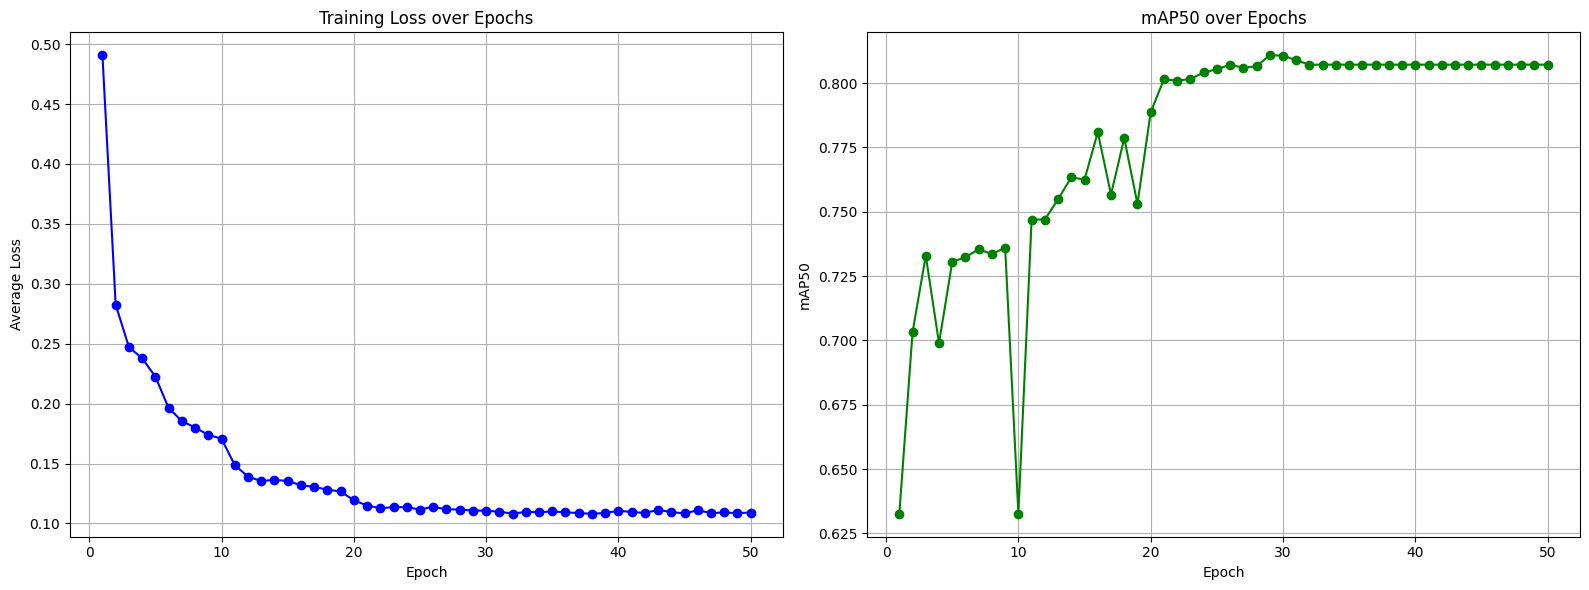


Final Model Comparison: Preprocessing Impact (mAP50 Mean)
Final mAP50: 0.8072
Best mAP50: 0.8108 at epoch 29
Average mAP50: 0.7780


In [38]:
# Loss와 mAP50 그래프
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss 그래프
ax1.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.set_title('Training Loss over Epochs')
ax1.grid(True)

# mAP50 그래프
ax2.plot(range(1, len(map50_scores) + 1), map50_scores, marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('mAP50')
ax2.set_title('mAP50 over Epochs')
ax2.grid(True)

plt.tight_layout()
plt.show()

# 최종 결과 출력
print(f"\nFinal Model Comparison: Preprocessing Impact (mAP50 Mean)")
print(f"{'='*60}")
print(f"Final mAP50: {map50_scores[-1]:.4f}")
print(f"Best mAP50: {max(map50_scores):.4f} at epoch {map50_scores.index(max(map50_scores)) + 1}")
print(f"Average mAP50: {sum(map50_scores) / len(map50_scores):.4f}")
print(f"{'='*60}")

## 11. 추론 함수 정의

In [39]:
def run_inference(model, image_path, device, confidence_threshold=0.5):
    """단일 이미지에 대한 추론"""
    # 이미지 로드
    img = Image.open(image_path).convert('RGB')
    img_tensor = transforms.ToTensor()(img)
    img_tensor = img_tensor.to(device)

    # 추론 모드
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor])

    # 예측 결과 추출
    pred = predictions[0]
    boxes = pred['boxes'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()

    # confidence threshold 적용
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]

    return img, boxes, labels, scores


def visualize_predictions(img, boxes, labels, scores, save_path=None):
    """예측 결과를 이미지에 시각화"""
    draw = ImageDraw.Draw(img)

    # 폰트 설정
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    except:
        font = ImageFont.load_default()

    # 색상 목록
    colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'purple']

    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        x_min, y_min, x_max, y_max = box
        color = colors[int(label) % len(colors)]

        # 바운딩 박스 그리기
        draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=3)

        # 라벨과 confidence score 그리기
        text = f"Class {label}: {score:.2f}"
        draw.text((x_min, y_min - 25), text, fill=color, font=font)

    # 이미지 저장
    if save_path:
        img.save(save_path)
        print(f"Saved visualization to {save_path}")

    return img

## 12. 테스트 이미지 추론

In [40]:
# 출력 디렉토리 생성
OUTPUT_DIR = './test_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 테스트 이미지 파일 목록
test_images = sorted(glob.glob(os.path.join(TEST_IMAGE_DIR, '*.png')))
print(f"Found {len(test_images)} test images")

# Confidence threshold 설정
CONFIDENCE_THRESHOLD = 0.5

Found 22 test images


## 13. 전체 테스트 이미지에 대한 추론

In [41]:
import csv

# 각 이미지에 대해 추론 수행
results_data = []  # CSV 저장용 데이터

for img_path in test_images:
    img_name = os.path.basename(img_path)
    print(f"\nProcessing {img_name}...")

    # 추론
    img, boxes, labels, scores = run_inference(model, img_path, device, CONFIDENCE_THRESHOLD)

    print(f"  Detected {len(boxes)} objects")

    # 각 객체에 대한 정보 저장
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        x_min, y_min, x_max, y_max = box

        # 결과 데이터 추가
        results_data.append({
            'image_name': img_name,
            'object_id': i + 1,
            'class_id': int(label),
            'confidence': float(score),
            'x_min': float(x_min),
            'y_min': float(y_min),
            'x_max': float(x_max),
            'y_max': float(y_max),
            'width': float(x_max - x_min),
            'height': float(y_max - y_min)
        })

        print(f"    Object {i+1}: Class {label}, Score: {score:.4f}")

    # 시각화 및 저장
    output_path = os.path.join(OUTPUT_DIR, f"pred_{img_name}")
    visualize_predictions(img, boxes, labels, scores, output_path)

# CSV 파일 저장
csv_path = '/content/result.csv'
csv_fields = ['image_name', 'object_id', 'class_id', 'confidence', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height']

with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
    writer.writeheader()
    writer.writerows(results_data)

print(f"\nInference completed!")
print(f"Results saved to {OUTPUT_DIR}")
print(f"CSV file saved to {csv_path}")
print(f"Total detections: {len(results_data)}")


Processing 1019.png...
  Detected 4 objects
    Object 1: Class 1, Score: 0.9904
    Object 2: Class 1, Score: 0.9545
    Object 3: Class 1, Score: 0.9500
    Object 4: Class 1, Score: 0.8758
Saved visualization to ./test_results/pred_1019.png

Processing 1025.png...
  Detected 4 objects
    Object 1: Class 1, Score: 0.9791
    Object 2: Class 1, Score: 0.9322
    Object 3: Class 1, Score: 0.8769
    Object 4: Class 1, Score: 0.7758
Saved visualization to ./test_results/pred_1025.png

Processing 1030.png...
  Detected 4 objects
    Object 1: Class 1, Score: 0.9718
    Object 2: Class 1, Score: 0.9558
    Object 3: Class 1, Score: 0.9031
    Object 4: Class 1, Score: 0.8994
Saved visualization to ./test_results/pred_1030.png

Processing 1186.png...
  Detected 4 objects
    Object 1: Class 1, Score: 0.9814
    Object 2: Class 1, Score: 0.9421
    Object 3: Class 1, Score: 0.9238
    Object 4: Class 1, Score: 0.7986
Saved visualization to ./test_results/pred_1186.png

Processing 1192.png

## 14. 샘플 결과 시각화

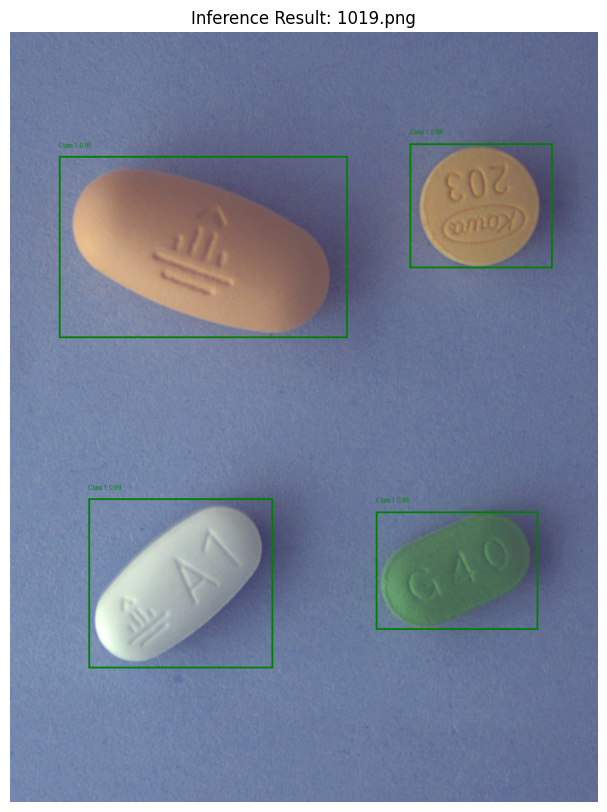


Detected 4 objects:
  Object 1: Class 1, Confidence: 0.9904, Box: [ 130.13635  775.928    436.63885 1057.156  ]
  Object 2: Class 1, Confidence: 0.9545, Box: [ 81.45384 206.74553 560.3132  508.6708 ]
  Object 3: Class 1, Confidence: 0.9500, Box: [607.9304  797.13855 876.8718  993.65045]
  Object 4: Class 1, Confidence: 0.8758, Box: [663.72076 185.1942  900.2883  392.81696]


In [42]:
# 첫 번째 테스트 이미지에 대한 결과 시각화
if len(test_images) > 0:
    sample_test_img = test_images[0]
    img, boxes, labels, scores = run_inference(model, sample_test_img, device, CONFIDENCE_THRESHOLD)

    # 결과 출력
    img_with_boxes = visualize_predictions(img.copy(), boxes, labels, scores)

    # matplotlib으로 표시
    plt.figure(figsize=(15, 10))
    plt.imshow(img_with_boxes)
    plt.title(f"Inference Result: {os.path.basename(sample_test_img)}")
    plt.axis('off')
    plt.show()

    print(f"\nDetected {len(boxes)} objects:")
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        print(f"  Object {i+1}: Class {label}, Confidence: {score:.4f}, Box: {box}")

## 15. 결과 요약

In [43]:
print("=" * 60)
print("학습 및 추론 완료!")
print("=" * 60)
print(f"학습된 클래스 수: {dataset.num_classes}")
print(f"학습 이미지 수: {len(dataset)}")
print(f"테스트 이미지 수: {len(test_images)}")
print(f"최종 모델 저장 경로: {MODEL_SAVE_PATH}")
print(f"추론 결과 저장 경로: {OUTPUT_DIR}")
print("=" * 60)

학습 및 추론 완료!
학습된 클래스 수: 19
학습 이미지 수: 137
테스트 이미지 수: 22
최종 모델 저장 경로: /content/models/faster_rcnn_pill_model.pth
추론 결과 저장 경로: ./test_results
